In [2]:
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import backend as K
from PIL import Image

In [1]:
patch_size = 256
train_image_dir = r"C:\all files for block B\Y2B_24\images\train_p"
train_mask_dir = r"C:\all files for block B\Y2B_24\masks\train_p"
# for validation I use images labeled “val_…” in Y2B_24
test_image_dir = r"C:\all files for block B\Y2B_24\images\val_patched"
test_mask_dir = r"C:\all files for block B\Y2B_24\masks\val_patched_m"

In [3]:
# Function extracts identifier from file names
def get_identifier(file_name):
    """
    Extracts a common identifier from file names, ensuring consistency for image and mask matching.
    Handles `_mask` suffix in mask filenames.
    """
    base_name = os.path.basename(file_name)

    base_name = base_name.replace(".tif", "").replace(".png", "")

    base_name = base_name.replace("_mask", "").replace("_root", "").replace("_seed", "").replace("_shoot", "")
    return base_name

In [4]:
#function finds pairs of images and masks by matching their identifiers
def find_image_mask_pairs(image_dir, mask_dir, root_only=False):
    """
    Finds matched pairs of images and masks based on file names.
    If `root_only` is True, only considers masks with `_root` in their filenames.
    """
    images = {
        get_identifier(f): os.path.join(image_dir, f)
        for f in os.listdir(image_dir)
        if f.endswith('.png')
    }
    masks = {
        get_identifier(f): os.path.join(mask_dir, f)
        for f in os.listdir(mask_dir)
        if f.endswith('.tif') and (not root_only or "_root" in f)
    }

    common_keys = set(images.keys()).intersection(set(masks.keys()))

    pairs = [(images[key], masks[key]) for key in common_keys]
    return pairs

In [5]:
# function to load images from paths, resize them
def load_images(paths, target_size=None, grayscale=True):
    
    arrays = []
    for path in paths:
        img = Image.open(path)
        if grayscale:
            img = img.convert('L')  
        if target_size is not None:
            img = img.resize(target_size) 
        
        arr = np.array(img, dtype=np.float32)
        if arr.max() > 1:
            arr = arr / 255.0  
        
        arr = arr[..., np.newaxis]
        arrays.append(arr)
    
    return np.stack(arrays) if arrays else np.array([])


In [7]:
# finding pairs for training
train_pairs = find_image_mask_pairs(train_image_dir, train_mask_dir)
x_train_paths = [pair[0] for pair in train_pairs]
y_train_paths = [pair[1] for pair in train_pairs]

# finding pairs for validation (yes, i know that i named it test, but it is actually validation)
test_pairs = find_image_mask_pairs(test_image_dir, test_mask_dir)
x_test_paths = [pair[0] for pair in test_pairs]
y_test_paths = [pair[1] for pair in test_pairs]

# subsetting data to speed up training
subset_size = 10000  

x_train_paths = x_train_paths[:subset_size]
y_train_paths = y_train_paths[:subset_size]

# Load the datasets
x_train = load_images(x_train_paths)
y_train = load_images(y_train_paths)
x_test = load_images(x_test_paths)
y_test = load_images(y_test_paths)


In [8]:
# defining f1
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
model = Sequential()

# imput layer: dense layer helps reduce dimensions
model.add(Dense(200, input_shape=(256, 256, 1), activation='relu')) # input shape (256, 256, 1)

# downsampling 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
# downsampling 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
# bottleneck
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
# upsampling 1
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
# upsampling 2
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# output layer
model.add(Conv2D(1, (1, 1), activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256, 256, 200)     400       
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      57632     
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      1

In [10]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', # for binary classification
              metrics=['accuracy', f1])

In [11]:
# defining early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# training the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=7,          # only 7 epochs, because of long training time
    batch_size=16,
    callbacks=[early_stopping] # early stopping to prevent overfitting (but it is not really necessary for my model, since it has only 10 epochs)
)


Epoch 1/7
625/625 [==============================] - 5243s 8s/step - loss: 0.1802 - accuracy: 0.9745 - f1: 0.1050 - val_loss: 0.0242 - val_accuracy: 0.9967 - val_f1: 0.3364
Epoch 2/7
625/625 [==============================] - 7354s 12s/step - loss: 0.0617 - accuracy: 0.9879 - f1: 0.3975 - val_loss: 0.0167 - val_accuracy: 0.9969 - val_f1: 0.2528
Epoch 3/7
625/625 [==============================] - 5260s 8s/step - loss: 0.0599 - accuracy: 0.9883 - f1: 0.4826 - val_loss: 0.0174 - val_accuracy: 0.9974 - val_f1: 0.4571
Epoch 4/7
625/625 [==============================] - 5331s 9s/step - loss: 0.0596 - accuracy: 0.9883 - f1: 0.4884 - val_loss: 0.0247 - val_accuracy: 0.9962 - val_f1: 0.0050
Epoch 5/7
625/625 [==============================] - 4664s 7s/step - loss: 0.0591 - accuracy: 0.9885 - f1: 0.5181 - val_loss: 0.0353 - val_accuracy: 0.9982 - val_f1: 0.6108
Epoch 6/7
625/625 [==============================] - 4543s 7s/step - loss: 0.0587 - accuracy: 0.9885 - f1: 0.5299 - val_loss: 0.0188 -

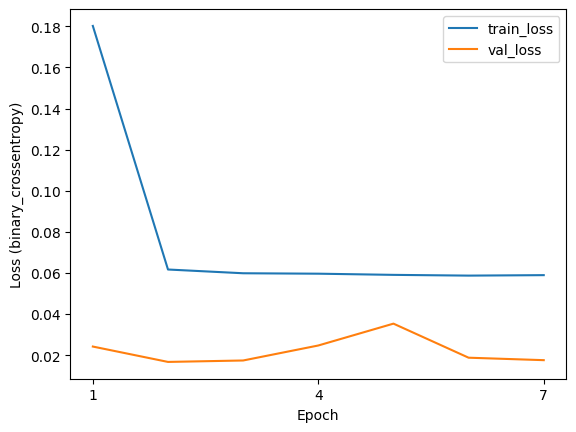

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

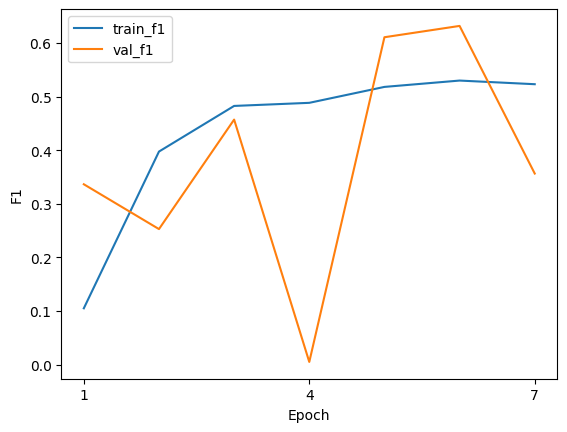

In [24]:
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

In [17]:
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.016697853803634644
Best validation f1: 0.6318885087966919


In [16]:
y_pred = model.predict(x_test)

174/174 [==============================] - 491s 3s/step


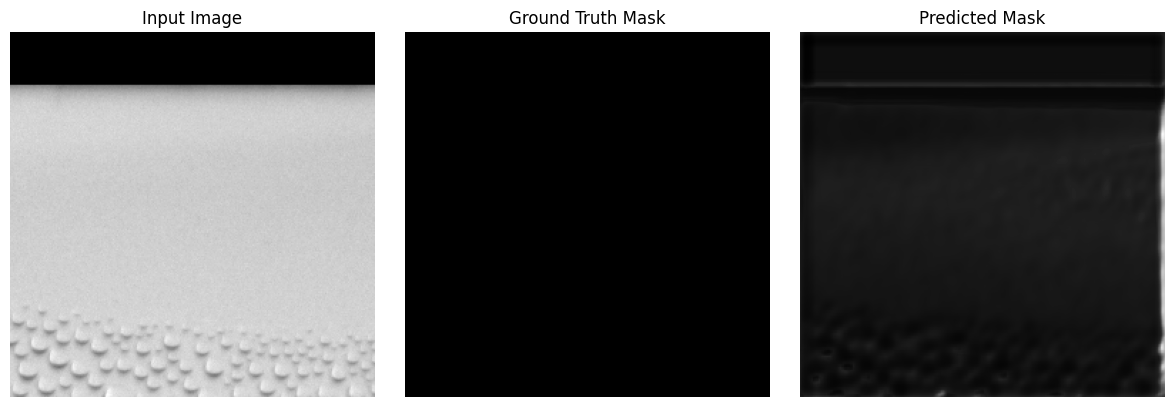

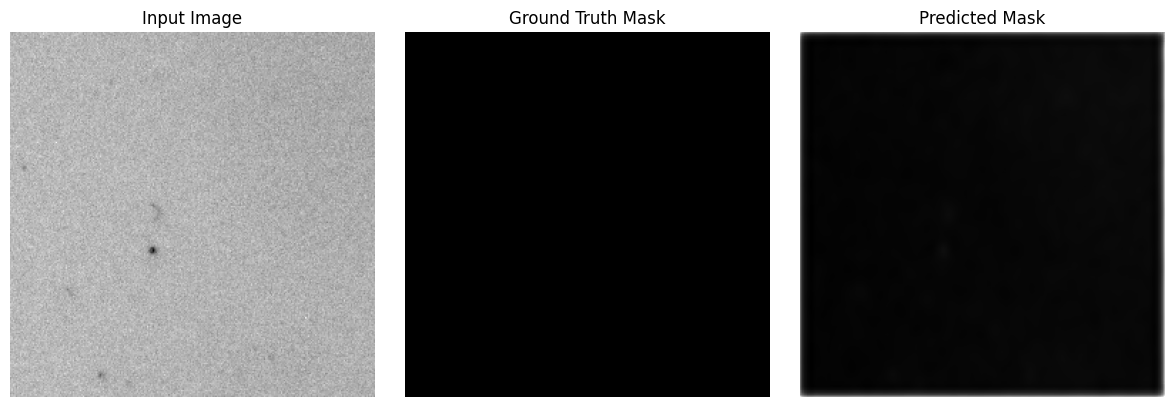

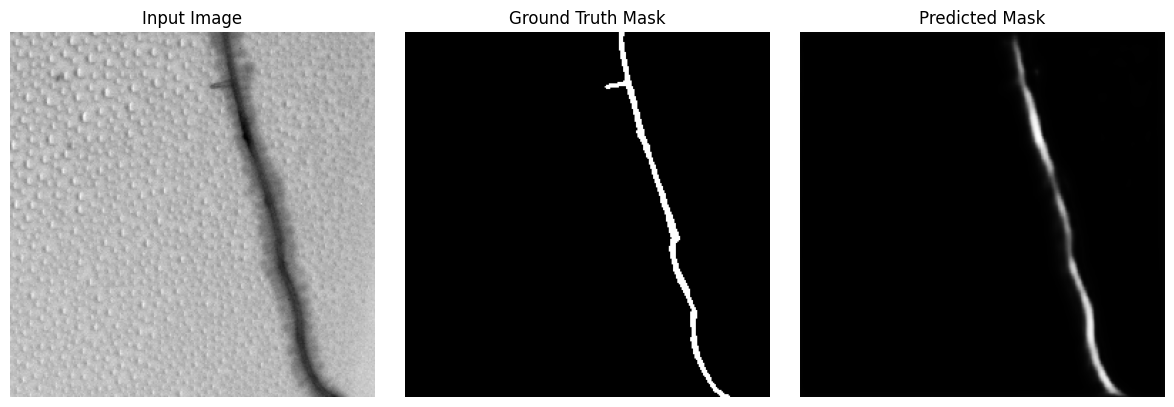

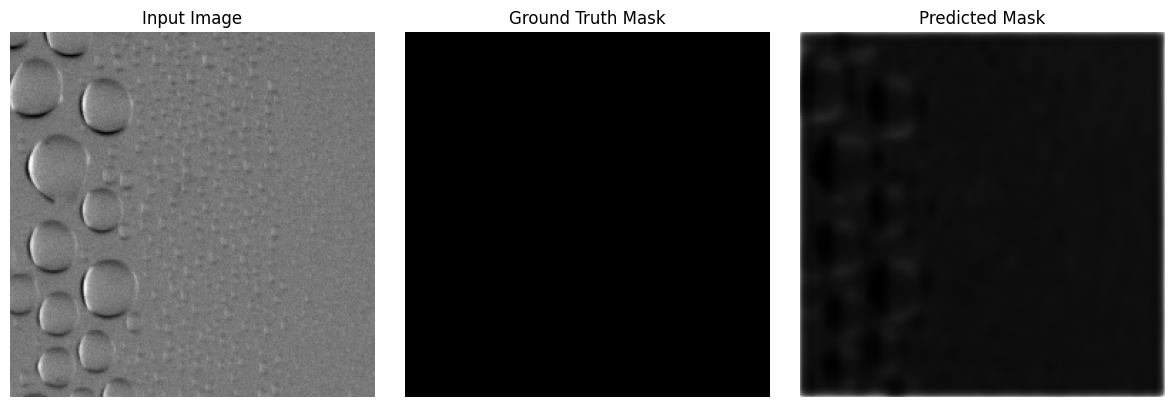

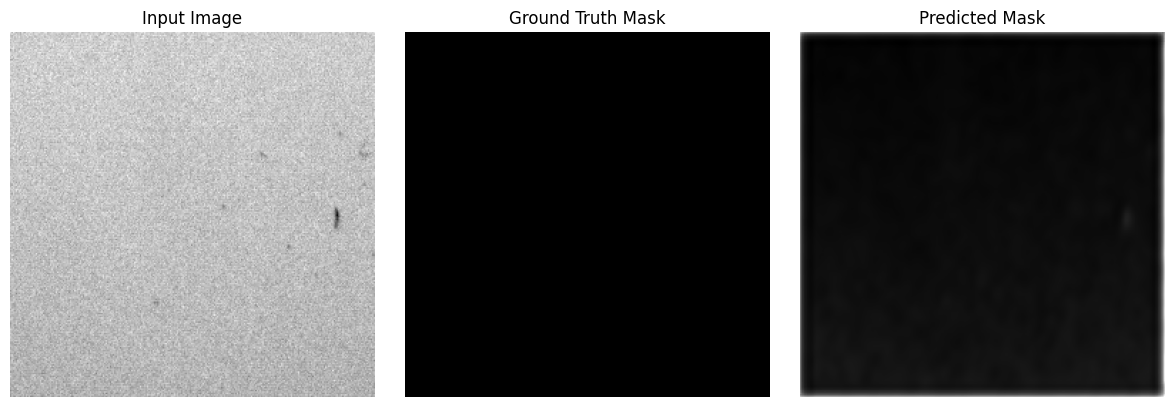

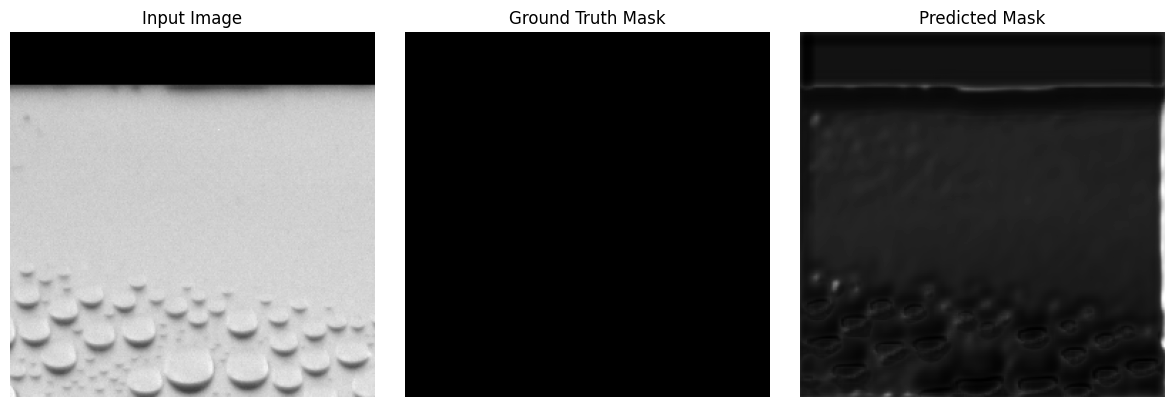

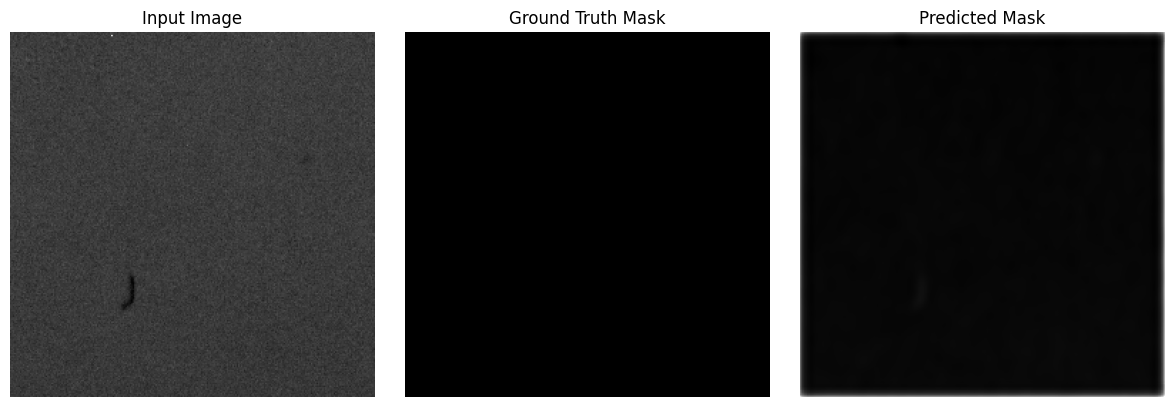

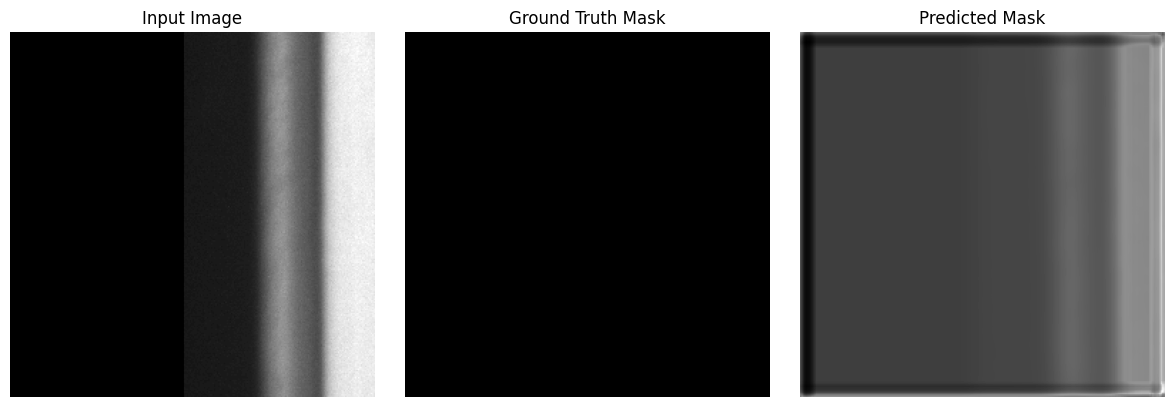

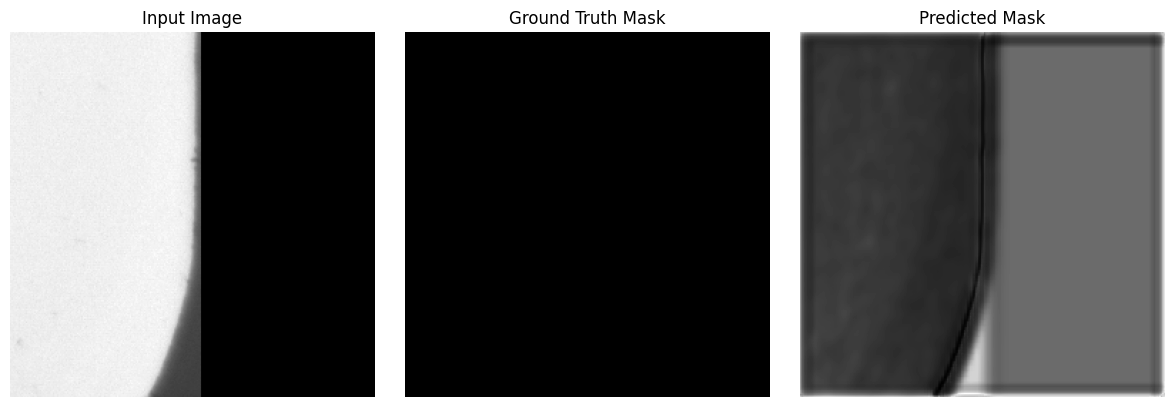

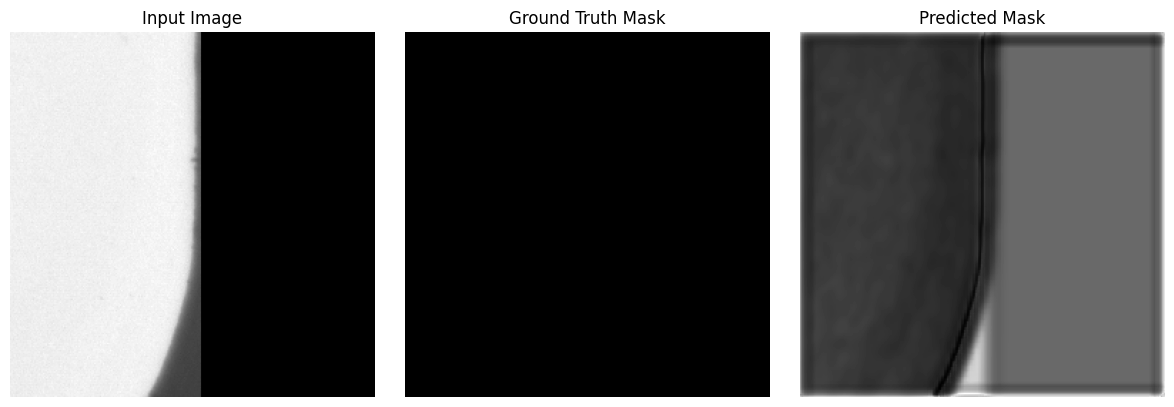

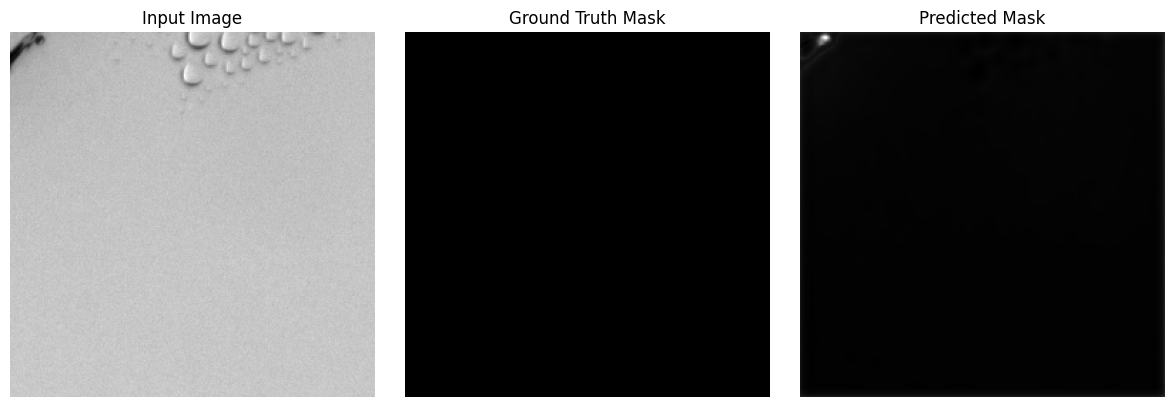

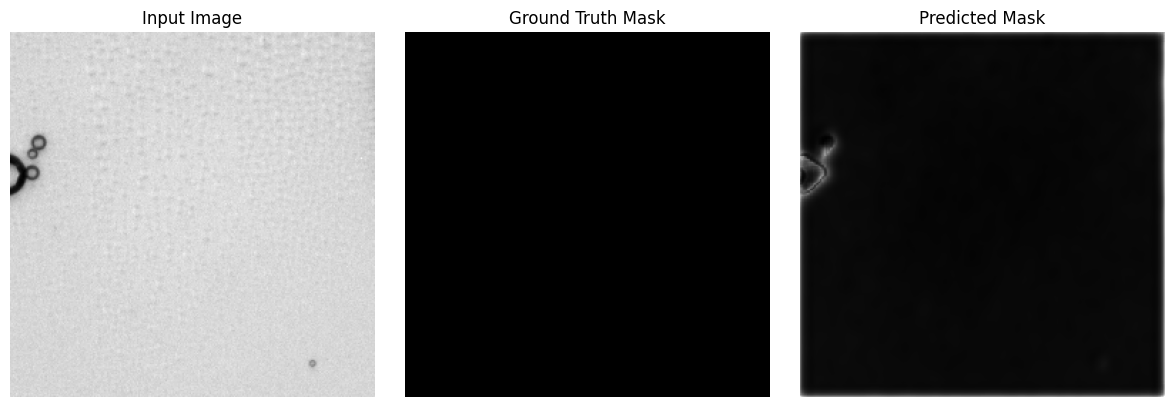

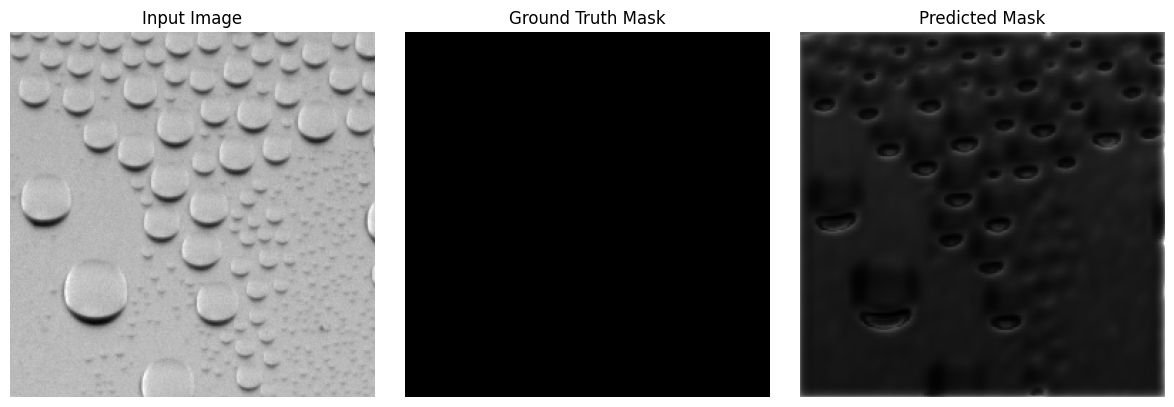

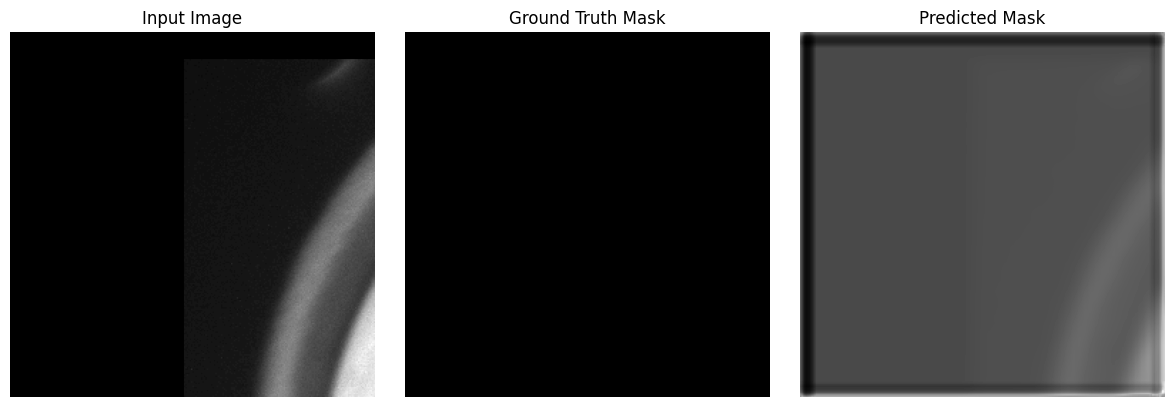

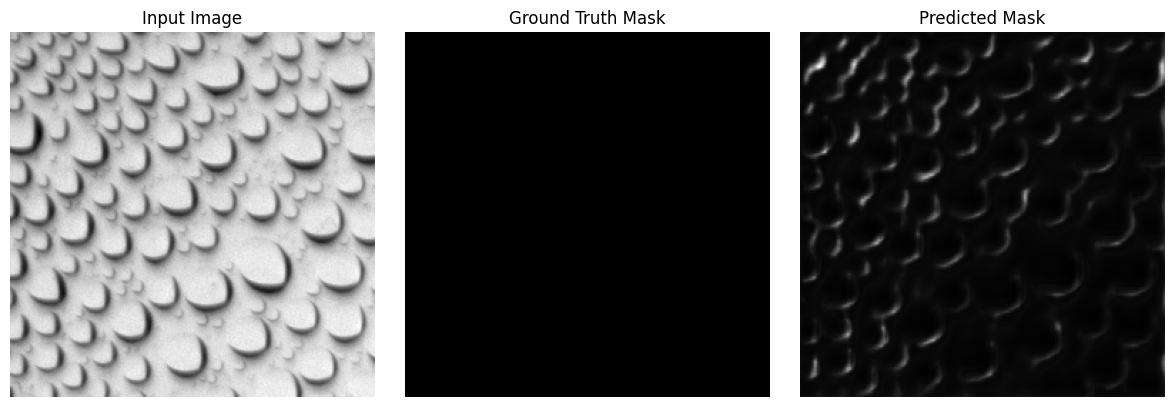

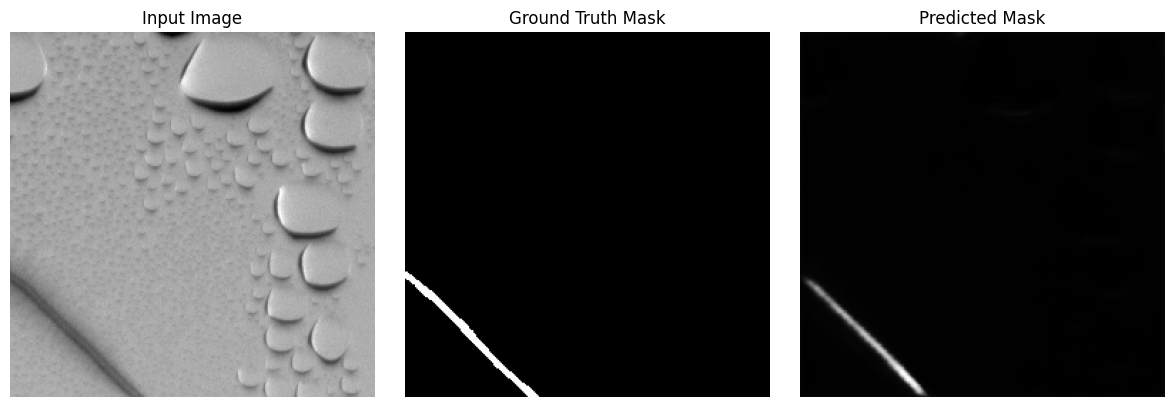

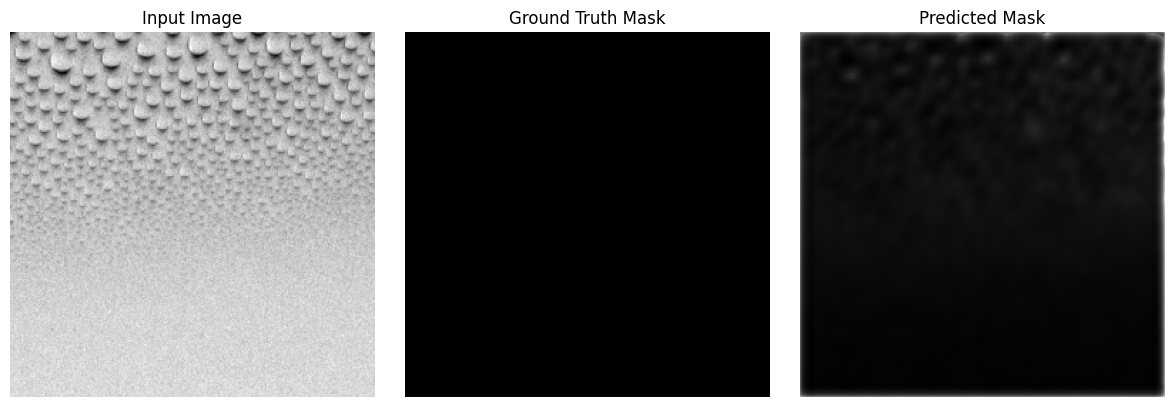

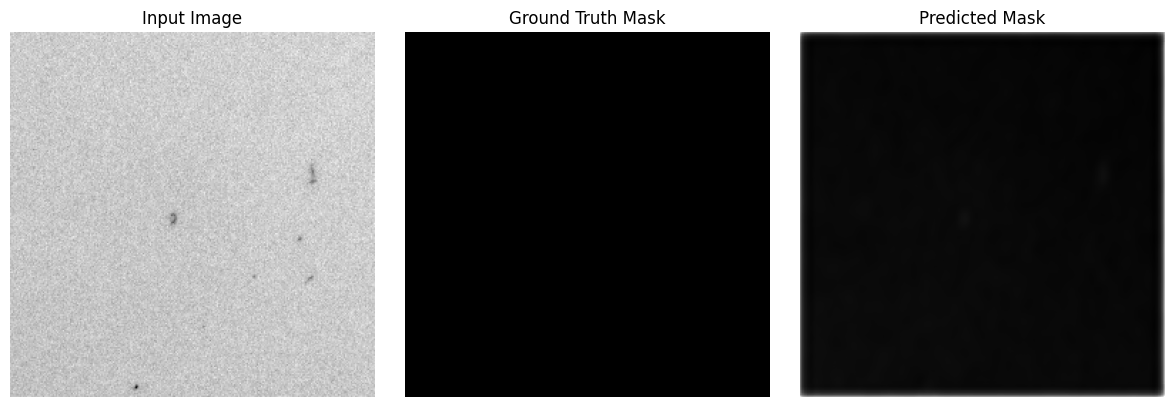

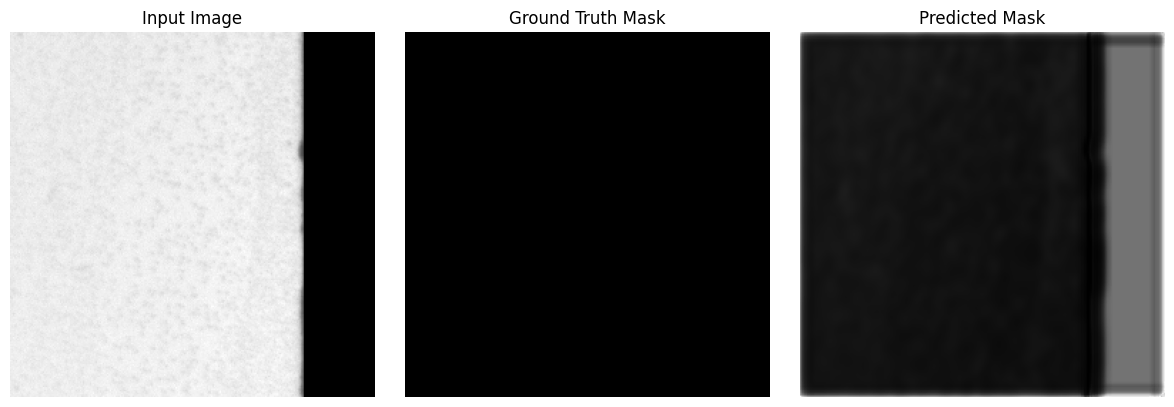

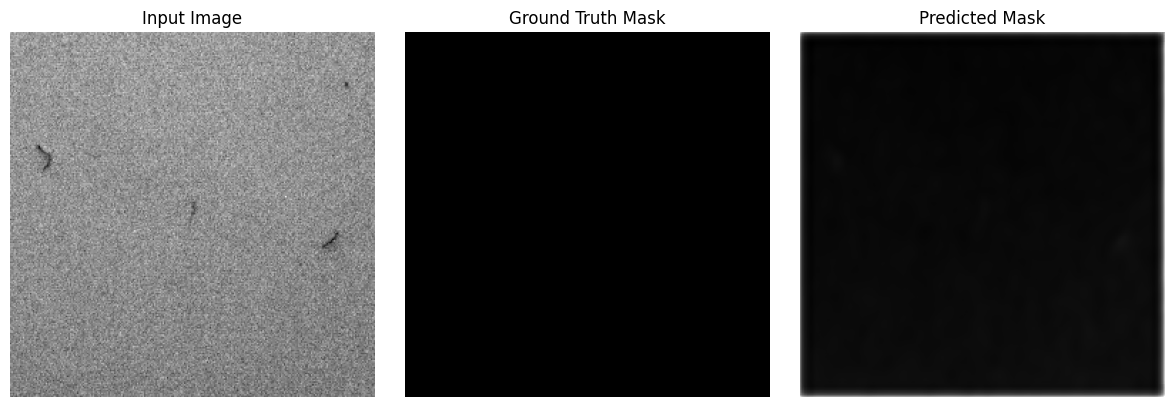

In [18]:

num_images = 20  
for i in range(num_images):
    plt.figure(figsize=(12, 4))

    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # Oryginal mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [21]:
file_name = f'Monika_Stangenberg_231648_unet_model_256px.h5'
print(file_name)
model.save(file_name)

Monika_Stangenberg_231648_unet_model_256px.h5
